# Time Series specificities - Practical Application

This notebook is following the progression of the Time Series specificities class. It provides practical illustrations in Python to understand the notions we have seen in this course.

<div class="alert alert-warning">
Author: Fabrice JIMENEZ
    
Link to course materials: https://github.com/jfabrice/ml-class-time-series
</div>

## Table of contents

[Preliminary loading with Google Colab](#Preliminary-loading-with-Google-Colab)<br>
[Imports and dataset presentation](#Imports-and-dataset-presentation)<br>

[1- Formulate the question](#1--Formulate-the-question)<br>
[2- Preprocessing](#2--Preprocessing)<br>
[3- Transformation steps](#3--Transformation-steps)<br>
[4- Feature Engineering](#4--Feature-Engineering)<br>
[5- Regular approach](#5--Regular-approach)<br>
[6- Method validation](#6--Method-validation)<br>

[Conclusion](#Conclusion)

## Preliminary loading with Google Colab

If you are using this notebook with Google Colab, please execute first the following cells, to retrieve the GitHub repository content, set the working directory and install required dependencies. Otherwise, ignore these 3 cells and move to the next section.

In [ ]:
!git clone https://github.com/jfabrice/ml-class-time-series.git

In [ ]:
import os
os.chdir('ml-class-time-series')

In [ ]:
!pip install -r requirements.txt

## Imports and dataset presentation

![question](https://raw.githubusercontent.com/jfabrice/ml-class-time-series/master/data/question.PNG)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
df = pd.read_csv('data/dataset.csv')
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
print(df.shape)

(138289, 5)


In [4]:
df.head()

,cycle,p1,p2,p3,p4
time,,,,,
2001-01-01 00:00:00,1,-0.805191,-1.141993,-1.328327,-1.516693
2001-01-01 00:00:01,1,-0.805191,-1.134902,-1.320393,-1.505848
2001-01-01 00:00:02,1,-0.805191,-1.117304,-1.307167,-1.505848
2001-01-01 00:00:04,1,-0.848104,-1.112276,-1.285393,-1.429076
2001-01-01 00:00:05,1,-0.906958,-1.126579,-1.302869,-1.419230


How many cycles do we have? How many points per cycle?

In [5]:
df.groupby('cycle').count()

,p1,p2,p3,p4
cycle,,,,
1,5758,5758,5758,5758
2,15302,15302,15302,15302
3,470,470,470,470
4,1402,1402,1402,1402
5,7919,7919,7919,7919
6,15301,15301,15301,15301
7,6427,6427,6427,6427
8,12267,12267,12267,12267
9,15302,15302,15302,15302


There are 15 cycles, with very different number of points per cycle.

Let's visualize 1 parameter in time for each cycle to see how cycles are spread out.

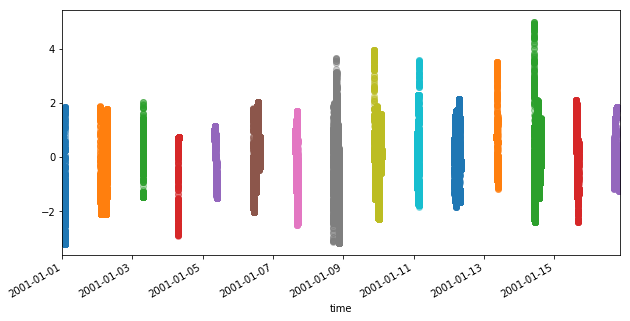

In [6]:
for c in df['cycle'].unique():
    df[df['cycle']==c]['p1'].plot(style='o', alpha=0.4)

Cycles seem to be separated in time by periods with no data. 

Let's see what our parameter looks like within a cycle.

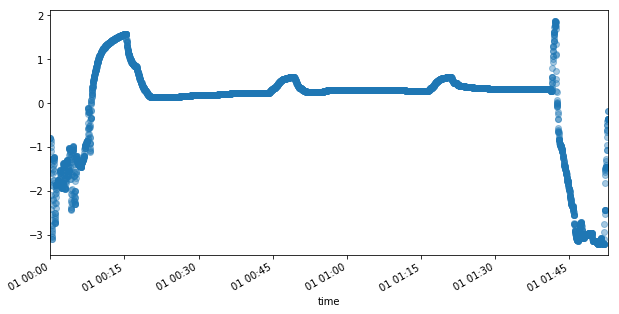

In [7]:
df[df['cycle']==1]['p1'].plot(style='o', alpha=0.4)

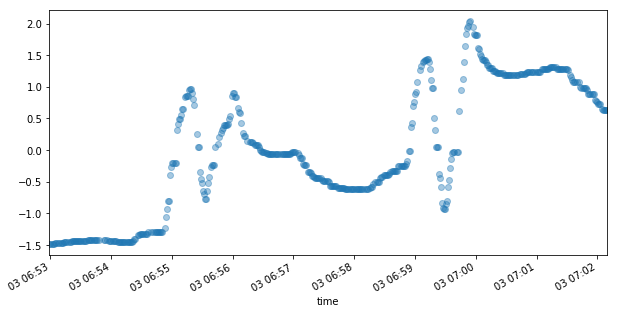

In [8]:
df[df['cycle']==3]['p1'].plot(style='o', alpha=0.4)

The values seem to be continuous (close in time = close in value) which is logical if they are physical parameters.

The parameter seems to behave quite differently in different cycles.

## 1- Formulate the question

<div class="alert alert-warning">
What is the task?
</div>

"Associate cycles which are similar" : this is a <b>clustering task</b>. Each cycle will be a sample and we will group similar samples with unsupervised clustering.

"Are some cycles really different from the rest?" : this is an <b>outlier detection</b> task. We can probably use the result of the clustering to identify samples which are far away from all group centers.

<div class="alert alert-warning">
What is the scale?
</div>

Given the task, we have no choice to consider the scale of the cycle as a unit. 1 sample will be composed of 4 time series (4 parameters) within a cycle.

In addition, we saw that the number of points is very different in each cycle, so we will have to summarize each cycle into a set of features.

## 2- Preprocessing

<div class="alert alert-warning">
Are there missing values?
</div>

In [9]:
df.isnull().sum()

cycle    0
p1       0
p2       0
p3       0
p4       0
dtype: int64

<div class="alert alert-warning">
Are the time steps all equal?
</div>

In [10]:
timescale = pd.Series(df.index)
timescale.diff().value_counts()

0 days 00:00:01    117466
0 days 00:00:02     17708
0 days 00:00:03      2677
0 days 00:00:04       359
0 days 00:00:05        50
0 days 00:00:06        13
1 days 00:00:01        11
1 days 00:00:02         3
0 days 00:00:07         1
Name: time, dtype: int64

Time steps are not always equal to 1 second...

Let's check an example of gap of 7 seconds, to see what strategy we could use.

In [11]:
timescale[timescale.diff() == pd.Timedelta('00:00:07')]

74001   2001-01-10 00:11:07
Name: time, dtype: datetime64[ns]

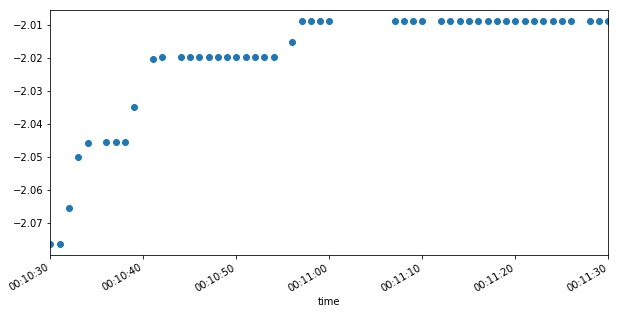

In [12]:
df['p1']['2001-01-10 00:10:30':'2001-01-10 00:11:30'].plot(style='o')

We see that values still seem to be continuous. This kind of gap can be interpolated with mean value.

We assume that gaps of more than 1 day correspond to time periods between cycles. Let's confirm that.

In [13]:
# Capture the gaps of more than 1 day
timescale[timescale.diff() >= pd.Timedelta(days=1)].reset_index()['time']

0    2001-01-02 01:52:55
1    2001-01-03 06:52:59
2    2001-01-04 07:02:11
3    2001-01-05 07:29:41
4    2001-01-06 10:04:58
5    2001-01-07 15:05:01
6    2001-01-08 17:11:02
7    2001-01-09 21:11:34
8    2001-01-11 02:11:37
9    2001-01-12 03:36:55
10   2001-01-13 08:36:56
11   2001-01-14 09:58:21
12   2001-01-15 14:58:24
13   2001-01-16 16:45:26
Name: time, dtype: datetime64[ns]

In [14]:
# Capture the start time of each cycle
df.reset_index().groupby('cycle').min().reset_index()['time']

0    2001-01-01 00:00:00
1    2001-01-02 01:52:55
2    2001-01-03 06:52:59
3    2001-01-04 07:02:11
4    2001-01-05 07:29:41
5    2001-01-06 10:04:58
6    2001-01-07 15:05:01
7    2001-01-08 17:11:02
8    2001-01-09 21:11:34
9    2001-01-11 02:11:37
10   2001-01-12 03:36:55
11   2001-01-13 08:36:56
12   2001-01-14 09:58:21
13   2001-01-15 14:58:24
14   2001-01-16 16:45:26
Name: time, dtype: datetime64[ns]

Indeed, the timestamps corresponding to these gaps are matching with the first point of each cycle.

<b>Conclusion</b>: We can resample data with equal steps of 1 second within each cycle, with mean interpolation (oversampling).

In [15]:
newdf = []

# For each cycle, create a small dataframe with interpolation
for c in df['cycle'].unique():
    tmp = df[df['cycle'] == c].copy()
    tmp = tmp.resample('1S').mean().interpolate(method='linear')
    
    newdf.append(tmp)
    
# Concatenate the results to have the complete dataframe
newdf = pd.concat(newdf, axis=0)
df = newdf.copy()
del newdf

Let's check we only have time steps of 1 second or 1 day (between cycles)

In [16]:
timescale = pd.Series(df.index)
timescale.diff().value_counts()

0 days 00:00:01    162684
1 days 00:00:01        11
1 days 00:00:02         3
Name: time, dtype: int64

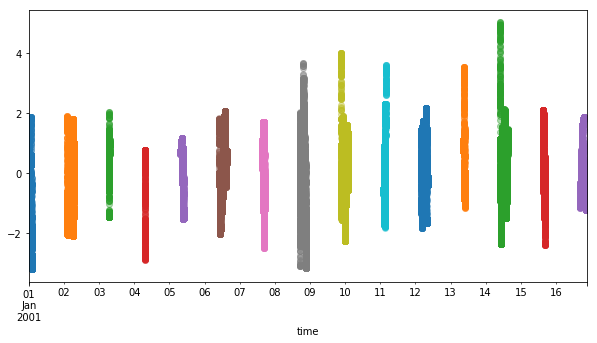

In [17]:
for c in df['cycle'].unique():
    df[df['cycle']==c]['p1'].plot(style='o', alpha=0.4)

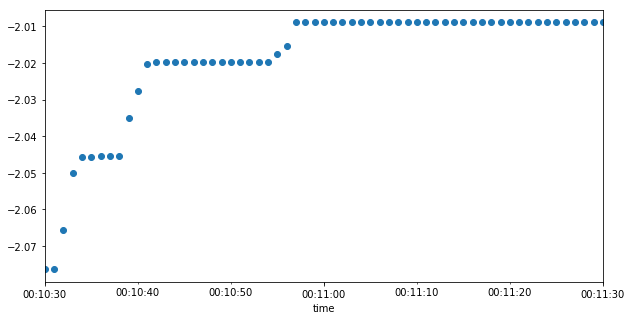

In [18]:
df['p1']['2001-01-10 00:10:30':'2001-01-10 00:11:30'].plot(style='o')

We now have clearly defined samples (windows) which contain time series regularly indexed.

## 3- Transformation steps

<div class="alert alert-warning">
1D: Can we exploit the structure of the data for each time series ?
</div>

When we look at the parameter values closely, we have a lot of constant steps, making the overall shape piecewise constant.

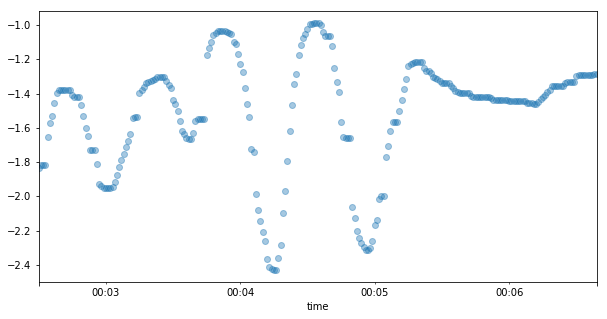

In [19]:
df[df['cycle'] == 1]['p1'][150:400].plot(style='o', alpha=0.4)

Intuitively, looking at the global shapes of signals, this kind of behavior will only add noise or pollution when we want to study the dynamics of the signal, for instance the frequencies, or the derivative. Let's filter our signals by applying a rolling mean, with a suitable window size making our signals smooth!

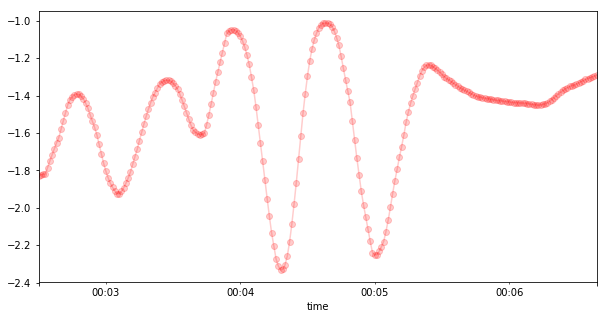

In [20]:
df[df['cycle'] == 1]['p1'][150:400].rolling('10S').mean().plot(style='r-o', alpha=0.2)

Let's apply it on all cycles and all parameters.

In [21]:
newdf = []

# For each cycle, create a small dataframe with rolling mean
for c in df['cycle'].unique():
    tmp = df[df['cycle'] == c].copy()
    tmp = tmp.rolling('10S').mean()
    
    newdf.append(tmp)
    
# Concatenate the results to have the complete dataframe
newdf = pd.concat(newdf, axis=0)
df = newdf.copy()
del newdf

As we said we want to study the dynamics of the system. Periodicity does not seem to be relevant due to the global shape of the signal across cycles. However, adding the derivative of each signal can bring information on the evolution of these signals. We keep the original signals also because the absolute quantities can also help discriminate behaviors.

In [22]:
derivatives = []

# For each cycle, create a small dataframe with derivative values of signals
for c in df['cycle'].unique():
    tmp = df[df['cycle'] == c].diff().drop('cycle',axis=1)
    tmp.columns = ['p1_diff','p2_diff','p3_diff','p4_diff']
    
    derivatives.append(tmp)
    
# Concatenate the results to have the complete dataframe
derivatives = pd.concat(derivatives, axis=0)
df = pd.concat([df,derivatives], axis=1).dropna(axis=0)
del derivatives

In [23]:
df.head()

,cycle,p1,p2,p3,p4,p1_diff,p2_diff,p3_diff,p4_diff
time,,,,,,,,,
2001-01-01 00:00:01,1.0,-0.805191,-1.138448,-1.324360,-1.511270,0.000000e+00,0.003545,0.003967,0.005423
2001-01-01 00:00:02,1.0,-0.805191,-1.131400,-1.318629,-1.509463,-1.110223e-16,0.007048,0.005731,0.001807
2001-01-01 00:00:03,1.0,-0.810555,-1.127247,-1.313042,-1.498963,-5.364125e-03,0.004152,0.005587,0.010500
2001-01-01 00:00:04,1.0,-0.818065,-1.124253,-1.307512,-1.484985,-7.509775e-03,0.002994,0.005530,0.013977
2001-01-01 00:00:05,1.0,-0.832880,-1.124641,-1.306738,-1.474026,-1.481552e-02,-0.000388,0.000774,0.010959


<div class="alert alert-warning">
nD: Can we exploit the structure of the data for 2 or more time series at a time?
</div>

Let's look at correlations and pairplots to study pairwise relationships

In [24]:
import seaborn as sns

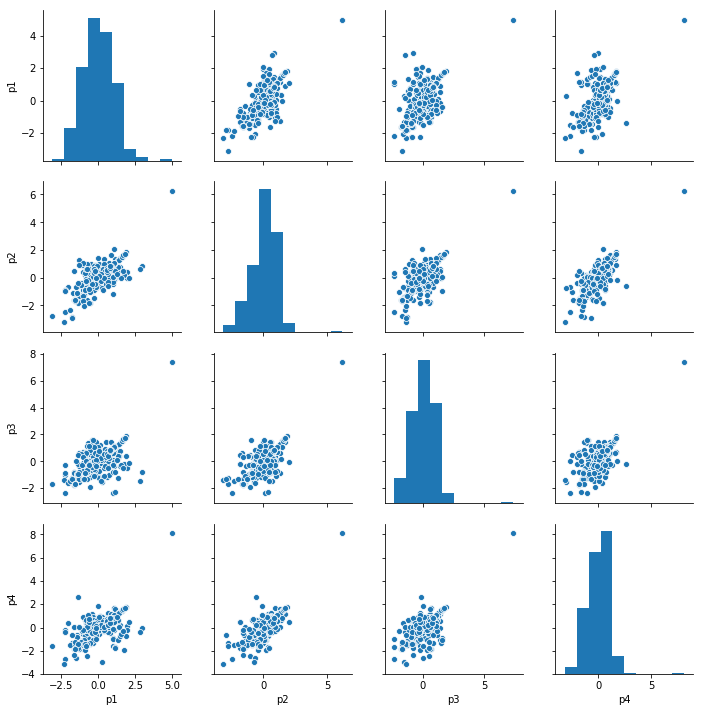

In [25]:
sns.pairplot(df[['p1','p2','p3','p4']].sample(300))

In [26]:
df[['p1','p2','p3','p4']].corr()

,p1,p2,p3,p4
p1,1.000000,0.743981,0.565222,0.644976
p2,0.743981,1.000000,0.682373,0.773222
p3,0.565222,0.682373,1.000000,0.676145
p4,0.644976,0.773222,0.676145,1.000000


There seems to be some correlation between parameters but not high enough to be used. Maybe PCA can give us more information by gathering all parameters. We don't need to scale our dataset because it is already scaled.

In [27]:
from sklearn.decomposition import PCA

In [28]:
pca = PCA(n_components=2)
resPCA = pca.fit_transform(df[['p1','p2','p3','p4']])
df['PC1'] = resPCA[:,0]
df['PC2'] = resPCA[:,1]

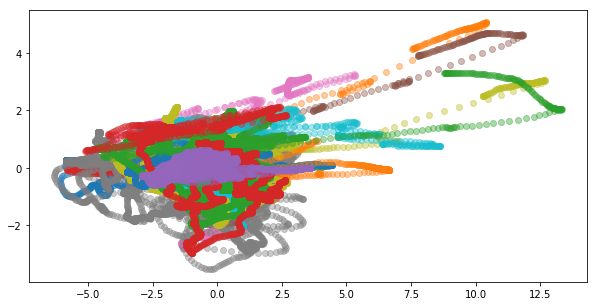

In [29]:
# Visualize PC1 - PC2 projection for each cycle
for c in df['cycle'].unique():
    plt.plot(df[df['cycle'] == c]['PC1'], df[df['cycle'] == c]['PC2'], 'o', alpha=0.4)

Some behaviors seem to be observable on the PC1 - PC2 axes, for certain cycles but not all. It might be interesting to keep PC1 and PC2 as variables.

In the end, we have our transformed time series in our dataset with derived information.

In [30]:
df.head()

,cycle,p1,p2,p3,p4,p1_diff,p2_diff,p3_diff,p4_diff,PC1,PC2
time,,,,,,,,,,,
2001-01-01 00:00:01,1.0,-0.805191,-1.138448,-1.324360,-1.511270,0.000000e+00,0.003545,0.003967,0.005423,-2.392796,-0.426358
2001-01-01 00:00:02,1.0,-0.805191,-1.131400,-1.318629,-1.509463,-1.110223e-16,0.007048,0.005731,0.001807,-2.385422,-0.423118
2001-01-01 00:00:03,1.0,-0.810555,-1.127247,-1.313042,-1.498963,-5.364125e-03,0.004152,0.005587,0.010500,-2.377811,-0.414681
2001-01-01 00:00:04,1.0,-0.818065,-1.124253,-1.307512,-1.484985,-7.509775e-03,0.002994,0.005530,0.013977,-2.370105,-0.404165
2001-01-01 00:00:05,1.0,-0.832880,-1.124641,-1.306738,-1.474026,-1.481552e-02,-0.000388,0.000774,0.010959,-2.371529,-0.391941


## 4- Feature Engineering

<div class="alert alert-warning">
What features can now be used to summarize each cycle?
</div>

To describe a cycle we want to estimate:
   - The distribution of parameter values: info contained in p1, p2, p3, p4
   - The distribution of parameter combination values (pairs or more): info contained in PC1 and PC2
   - The dynamics - evolution of parameter values: info contained in p1_diff, p2_diff, p3_diff, p4_diff

We could go further, compute Fast Fourier Transform and use the coefficients, or derivatives of principal components in time, etc. But for the sake of the exercise, and considering it is a first step, we will only keep basic features on the enriched time series we already have.

In [31]:
# Function to be applied to the dataframe of each cycle
def computeFeatures(tab):
    res = pd.Series()
    
    # For each time series we compute the following features
    for p in [c for c in tab.columns if c != 'cycle']:
        # Mean
        res[p+'_mean'] = tab[p].mean()
        # 1st decile
        res[p+'_d1'] = tab[p].quantile(0.1)
        # 9th decile
        res[p+'_d9'] = tab[p].quantile(0.9)
        # Standard deviation
        res[p+'_std'] = tab[p].std()
    
    return res

We apply the feature computation on each cycle.

In [32]:
features = df.groupby('cycle').apply(computeFeatures)
print(features.shape)

(15, 40)


In [33]:
features.head()

,p1_mean,p1_d1,p1_d9,p1_std,p2_mean,p2_d1,p2_d9,p2_std,p3_mean,p3_d1,...,p4_diff_d9,p4_diff_std,PC1_mean,PC1_d1,PC1_d9,PC1_std,PC2_mean,PC2_d1,PC2_d9,PC2_std
cycle,,,,,,,,,,,,,,,,,,,,,
1.0,-0.000287,-1.583831,0.592674,0.998753,-0.000547,-1.733597,0.582543,0.998700,-0.000953,-1.881348,...,0.001886,0.013919,-0.001372,-3.576056,1.179296,1.982523,-0.000581,-0.069552,0.034319,0.157067
2.0,0.000542,-1.758408,0.993330,0.999873,0.000652,-1.421760,0.996806,1.000686,0.001344,-1.550162,...,0.008278,0.014094,0.001470,-2.855604,1.488184,1.725152,0.000488,-0.793887,0.636192,0.673181
3.0,-0.011190,-1.436931,1.275644,0.992729,-0.009530,-0.926119,1.370160,0.977702,-0.009588,-1.298519,...,0.086964,0.070011,-0.019125,-1.925690,2.473536,1.843443,0.001107,-0.189744,0.191392,0.160602
4.0,-0.006006,-1.942619,0.713182,1.002226,-0.005982,-1.871209,0.669584,1.001830,-0.005866,-1.991679,...,0.005339,0.016125,-0.011804,-3.824108,1.364719,1.995873,-0.000011,-0.037193,0.017079,0.095667
5.0,0.000298,-1.388943,1.109749,0.999943,0.000269,-1.362800,1.104726,0.999886,0.000148,-1.377596,...,0.001215,0.006297,0.000344,-2.725626,2.212580,1.997585,-0.000194,-0.042861,0.015242,0.035700


## 5- Regular approach

<div class="alert alert-warning">
Clustering task
</div>

We have 15 cycles and 40 features. We are clearly doomed by the curse of dimensionality! Let's do a PCA to reduce the dimension, and we don't forget to scale our features, because they don't have the same units!

In [34]:
pca = PCA(n_components=5)
resPCA = pca.fit_transform((features - features.mean())/features.std())

Let's check we have a sufficient number of components to explain most of the variance:

In [35]:
pca.explained_variance_ratio_

array([0.48418954, 0.20166343, 0.12130714, 0.07951444, 0.04603047])

Now we can perform clustering on the PCA components, let's use a hierarchical clustering to see how many groups we should have.

In [36]:
from scipy.cluster import hierarchy

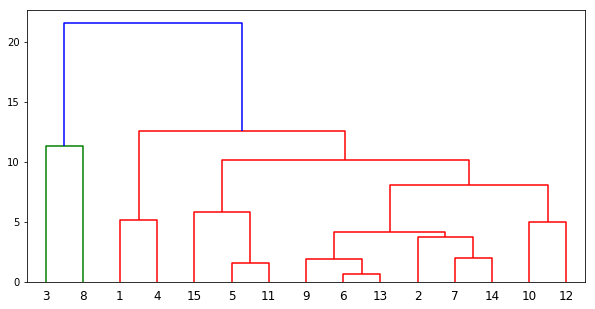

In [37]:
hac = hierarchy.linkage(resPCA, method='ward', metric='euclidean')
dendrogram = hierarchy.dendrogram(hac, labels=features.index.map(int))

A choice of 4 clusters seems reasonable! Let's cut the dendrogram at 4 groups.

In [38]:
features['cluster'] = hierarchy.cut_tree(hac,4).flatten()

Let's visualize the clusters in the PCA projection.

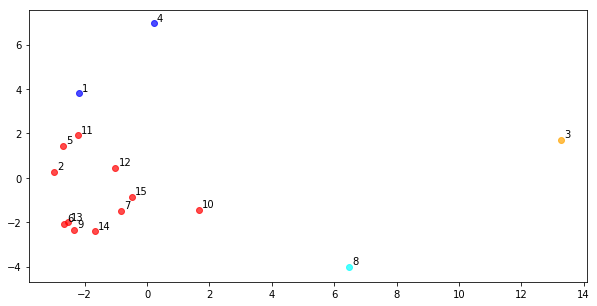

In [39]:
colors = ['blue','red','orange','cyan']
fig, ax = plt.subplots()
for i in range(len(features)):
    ax.scatter(resPCA[i,0], resPCA[i,1], c=colors[int(features.iloc[i]['cluster'])], alpha=0.7)
    ax.text(x=resPCA[i,0]+0.1, y=resPCA[i,1]+0.1, s=str(int(features.index[i])))

Let's visualize one of the time series of each cycle in the clusters.

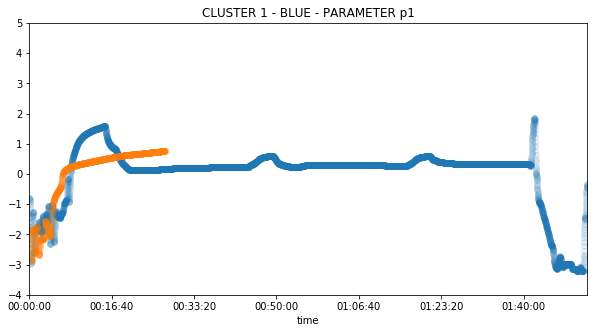

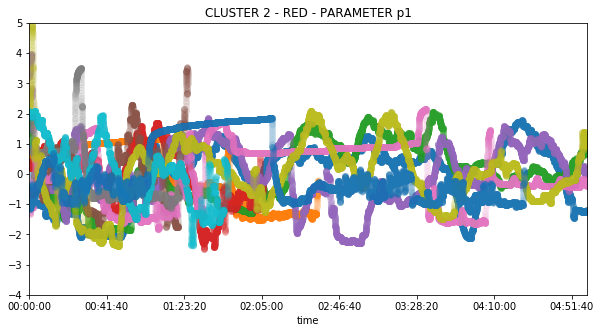

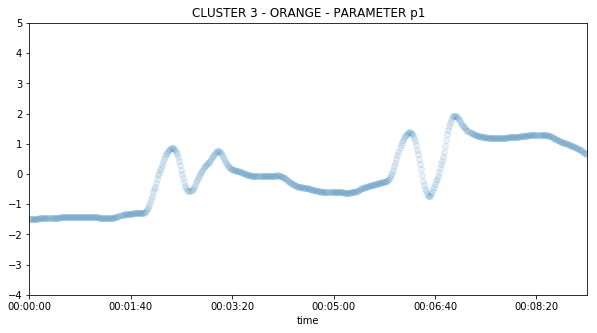

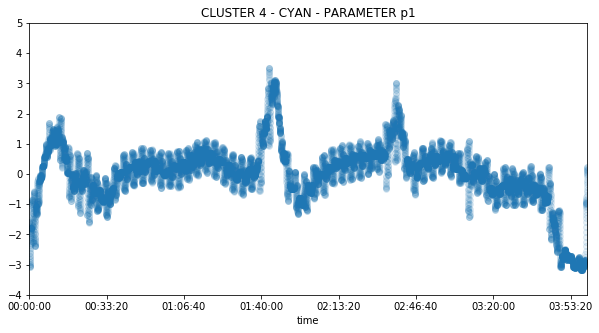

In [40]:
for cluster in range(4):
    plt.figure()
    plt.title('CLUSTER '+str(cluster+1)+' - '+colors[cluster].upper()+' - PARAMETER p1')
    for c in features.index:
        if features['cluster'][c] == cluster:
            tmp = df[df['cycle'] == c]['p1'].copy()
            tmp.index = tmp.index - tmp.index.min()
            tmp.plot(style='o', alpha=0.1)
    plt.ylim([-4,5])

<div class="alert alert-warning">
Outlier detection task
</div>

Our clustering task already revealed the outliers! Cycles 3 and 8 are clear outliers. A doubt remains on cycles 1 and 4, to be studied in validation phase...

## 6- Method validation

To validate our model, we need either: 
- a validation or test set, containing the ground truth (the clusters we had to find, the real anomalies...) - <b>Strong validation strategy</b>
- a human interpretation of the results (an expert eye who is able to tell if the clusters make sense, or if the anomalies detected are real ones...) - <b>Weak validation</b>

In the frame of this class, we don't have any validation dataset, so we would rely only on a human interpretation by an expert. According to their interpretation, we can go back in the different steps of this analysis to change some elements (different resampling, smoothing, transformation steps, choice of features, method for clustering...)

This is why it is very important not to get lost in your choices! To be able to play with these choices, to adjust according to the results validation. An idea could be to keep track with a simple schema like this one:

![pipeline](https://raw.githubusercontent.com/jfabrice/ml-class-time-series/master/data/pipeline.PNG)

## Conclusion

Always think first about the principles, the intuition, the qualitative aspect behind all the available functions you can find online.

- Many people can chain very complex algorithms together and get results which might be relevant for a problem.
- Only a few can make the right choices to quickly optimize the resolution of a problem and assess its feasability...